In [113]:
from rtd import refresh_vehicles
from amtrak import TrainTracker
import time
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

rtd_df = refresh_vehicles()
tt = TrainTracker()
tt.get_train_data()
amtrak_df = tt.get_denver_train_df()

time.sleep(15)
new_positions = refresh_vehicles()

position_comparison = new_positions[['vehicle_label', 'route_id', 'distance', 'vehicle_update_seconds_ago']].merge(rtd_df[['vehicle_label', 'distance', 'vehicle_update_seconds_ago']], on='vehicle_label', suffixes=['_new', '_old'], how='left').fillna(9999)
position_comparison['status'] = None
position_comparison.loc[(position_comparison['distance_new'] < 0.2) & (position_comparison['distance_old'] > 0.2), 'status'] = 'arriving'
position_comparison.loc[(position_comparison['distance_new'] < 0.2) & (position_comparison['distance_old'] < 0.2), 'status'] = 'at station'
position_comparison.loc[(position_comparison['distance_new'] > 0.2) & (position_comparison['distance_old'] < 0.2), 'status'] = 'departing'
position_comparison.loc[(position_comparison['distance_new'] > 0.2) & (position_comparison['distance_old'] > 0.2), 'status'] = 'away'

rtd_display = position_comparison.sort_values('distance_new')[['route_id', 'distance_new', 'vehicle_update_seconds_ago_new', 'status']].rename({'route_id': 'route', 'distance_new': 'distance', 'vehicle_update_seconds_ago_new': 'update_age'})

amtrak_display = amtrak_df[['train_num', 'dest', 'origin', 'velocity', 'status', 'actual_arrival', 'scheduled_arrival', 'estimated_arrival', 'actual_departure', 'scheduled_departure', 'estimated_departure']]
amtrak_display['relevant_datetime'] = amtrak_display['estimated_arrival']
amtrak_display.loc[amtrak_display['status'] == 'departed', 'relevant_datetime'] = amtrak_display['actual_departure']
amtrak_display.loc[amtrak_display['status'] == 'arrived', 'relevant_datetime'] = amtrak_display['estimated_departure']
amtrak_display['relevant_datetime'] = pd.to_datetime(amtrak_display['relevant_datetime'], format='%a %b %d, %I:%S%p')
amtrak_display = amtrak_display.sort_values('relevant_datetime')
amtrak_display['relevant_datetime'] = amtrak_display['relevant_datetime'].dt.strftime(' %I:%S%p %m/%d')

/tmp/ipykernel_16502/667869685.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amtrak_display['relevant_datetime'] = amtrak_display['estimated_arrival']
/tmp/ipykernel_16502/667869685.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amtrak_display['relevant_datetime'] = pd.to_datetime(amtrak_display['relevant_datetime'], format='%a %b %d, %I:%S%p')


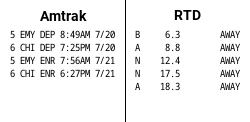

In [114]:
out = Image.new("RGB", (250, 122), (255, 255, 255))

fnt = ImageFont.truetype("../fonts/NotoSansMono_Condensed-Regular.ttf", 10)
titles = ImageFont.truetype("../fonts/Roboto-Bold.ttf", 14)
d = ImageDraw.Draw(out)

d.text(xy=(125/2,10), text='Amtrak', anchor='mt', font=titles, fill=(0,0,0))
d.text(xy=(250 - 125/2,10), text='RTD', anchor='mt', font=titles, fill=(0,0,0))
d.line(xy=[(125, 0), (125, 122)], fill=(0,0,0), width=1)

curr_y = 30
for index, row in amtrak_display.iterrows():
    d.text(xy=(125/2,curr_y), text=f"{row['train_num']} {row['dest']} {row['status'][:3].upper()} {row['relevant_datetime']}".replace(' 0', ' ').replace('  ', ' '), anchor='mt', font=fnt, fill=(0,0,0))
    curr_y += 13

curr_y = 30
for index, row in rtd_display.reset_index().iterrows():
    if index < 7:
        d.text(xy=(250 - 125/2,curr_y), text=f"{row['route_id'][-1]:<4} {round(row['distance_new'], 1):>4}  {row['status'].upper():>10}", anchor='mt', font=fnt, fill=(0,0,0))
        curr_y += 13

out.show()